# 実習4-2
### VGG16で転移学習をしてみる。

In [1]:
import os
from keras.applications.vgg16 import VGG16 #これでVGG16実装が簡単に
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras import optimizers
import numpy as np
import time

In [2]:
import urllib.request 

url = "https://www.dropbox.com/s/w0w2uyl2vhhw76o/byori_dataset.zip?dl=1" # 保存したいファイルのURLを指定 (dropboxのURLを指定する際は、最後のdl=0をdl=1に設定する)
save_name = "byori_dataset.zip" # byori_dataset.zipという名前で保存される。
 
# ダウンロードを実行
urllib.request.urlretrieve(url, save_name)

('byori_dataset.zip', <http.client.HTTPMessage at 0x7feea929c2e8>)

In [3]:
#uploadしたzipファイルを解凍する
import zipfile
with zipfile.ZipFile("byori_dataset.zip","r") as zip_ref:
    zip_ref.extractall("") #""の中にはディレクトリのpathが入る

In [4]:
# 分類するクラス
classes = ['normal','tumor'] 
nb_classes = len(classes)

# 画像サイズ、batch数、epoch数
img_width, img_height = 200, 200
batch_size = 20
nb_epoch = 10

In [5]:
# トレーニング用とバリデーション用の画像格納先
train_data_dir = 'byori_dataset/train'
validation_data_dir = 'byori_dataset/validation'

# 今回はトレーニング用に1000枚、バリデーション用に300枚の画像を用意した。
nb_train_samples = 1000
nb_validation_samples = 300

result_dir = 'byori_dataset/results'
if not os.path.exists(result_dir):
    os.mkdir(result_dir)

In [6]:
# vgg16モデルを作る
def vgg_model_maker():
    # VGG16のロード。FC層は不要なので include_top=False
    # weights='imagenet', これでIMAGENETで学習済みの重みが使える。
    # input_tensorは自分で画像を用意する時に使う。画像サイズを指定。
    input_tensor = Input(shape=(img_width, img_height, 3))
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

    # FC層を構築
    x = vgg16.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(nb_classes, activation='softmax')(x)

    
    # VGG16とFC層を接続
    model = Model(inputs=vgg16.input, outputs=predictions)
    
    return model

In [7]:
# ディレクトリ内の画像を読み込んでトレーニングデータとバリデーションデータの作成
def image_generator():
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)

    validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        color_mode='rgb',
        classes=classes,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True)

    validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        color_mode='rgb',
        classes=classes,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True)

    return (train_generator, validation_generator)

In [8]:
# モデル作成
vgg_model = vgg_model_maker()

# 14層目までのモデル重みを固定、最後のconv層の直前までの層の重みをfreeze
for layer in vgg_model.layers[:15]:
    layer.trainable = False
        
vgg_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
______________________________________________________________

In [9]:
# 多クラス分類を指定
vgg_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
                  metrics=['accuracy'])

# 画像のジェネレータ生成
train_generator, validation_generator = image_generator()
    
#vgg_model.load_weights('dataset/results/finetuning.h5')
    
start = time.time()
# Fine-tuning
hist = vgg_model.fit(
    train_generator,
    steps_per_epoch = nb_train_samples/batch_size,
    epochs = nb_epoch,
    verbose = 1,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples/batch_size)

vgg_model.save_weights(os.path.join(result_dir, 'finetuning.h5'))

process_time = (time.time() - start) / 60
print(u'学習終了。かかった時間は', process_time, u'分です。')

Found 2000 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Epoch 1/10
50/50 [==============================] - 19s 221ms/step - loss: 0.4132 - accuracy: 0.8002 - val_loss: 0.3696 - val_accuracy: 0.8800
Epoch 2/10
50/50 [==============================] - 11s 214ms/step - loss: 0.0450 - accuracy: 0.9868 - val_loss: 0.2215 - val_accuracy: 0.9167
Epoch 3/10
50/50 [==============================] - 11s 214ms/step - loss: 0.0525 - accuracy: 0.9880 - val_loss: 0.2724 - val_accuracy: 0.8967
Epoch 4/10
50/50 [==============================] - 11s 215ms/step - loss: 0.0207 - accuracy: 0.9929 - val_loss: 0.2444 - val_accuracy: 0.9233
Epoch 5/10
50/50 [==============================] - 11s 214ms/step - loss: 0.0397 - accuracy: 0.9937 - val_loss: 0.2117 - val_accuracy: 0.9233
Epoch 6/10
50/50 [==============================] - 11s 213ms/step - loss: 0.0113 - accuracy: 0.9961 - val_loss: 0.2695 - val_accuracy: 0.9167
Epoch 7/10
50/50 [==============================] - 11s 215

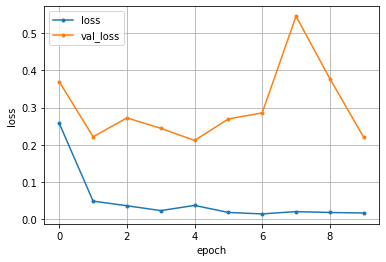

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = hist.history['loss']
val_loss = hist.history['val_loss']

# lossのグラフ
plt.plot(range(nb_epoch), loss, marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

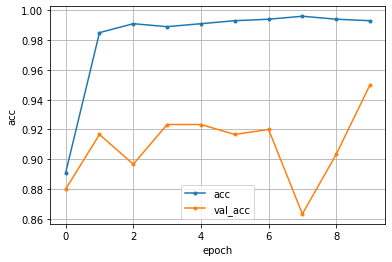

In [11]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# accuracyのグラフ
plt.plot(range(nb_epoch), acc, marker='.', label='acc')
plt.plot(range(nb_epoch), val_acc, marker='.', label='val_acc')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

In [12]:
#Plotlyを使用してプロットしてみる。
!pip install plotly

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

configure_plotly_browser_state()


import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

##データの元を作る,複数書きたい場合はこれを繰り返す
trace  = go.Scatter(y = hist.history['val_accuracy'],
                    x=np.arange(1,201) ,
                    name = 'val_accuracy',
                    mode = 'lines')
trace1 = go.Scatter(y = hist.history['val_loss'],
                    x=np.arange(1,201) ,
                    name = 'val_loss',
                    mode = 'lines')

data = [trace,trace1]


##データのレイアウトを決める
layout = go.Layout(
    title='Fine-Tuning cancer or normal',
    legend={"x":0.8, "y":0.5},#legendそのままにしたいならshowlegend = True

    xaxis={"title":"epoch"},#軸の最大値最小値を決めたいならここに"range": [最小値,最大値]のように記入
    yaxis={"title":"accuracy"}
)

##データをプロット
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,show_link = False)#グラフ表示のExport to plotly を消すにはここにshow_link=Falseのように記入


In [13]:
#＜＜スレットスコアを表示してみる＞＞

from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img

def normalization(data):
    data = data.astype("float32")
    data = data / 255.0
    return data

X = []
Y = []
file_path_list = []

#validation画像の読み込み
predict_dir = 'byori_dataset/validation/tumor/'
for picture in os.listdir(predict_dir):
        file_path_list.append(os.getcwd()+'/byori_dataset/validation/tumor/' + picture)
        # 画像の読み込み
        img = load_img(os.getcwd()+'/byori_dataset/validation/tumor/' + picture, target_size=(200, 200))
        img = img_to_array(img)
        X.append(img)
# Numpy の array に変換
X = np.asarray(X)
#   正規化
X = normalization(X)

predict_dir = 'byori_dataset/validation/normal/'
for picture in os.listdir(predict_dir):
        file_path_list.append(os.getcwd()+'/byori_dataset/validation/normal/' + picture)
        # 画像の読み込み
        img = load_img(os.getcwd()+'/byori_dataset/validation/normal/' + picture, target_size=(200, 200))
        img = img_to_array(img)
        Y.append(img)
# Numpy の array に変換
Y = np.asarray(Y)
#   正規化
Y = normalization(Y)


TP = 0
FP = 0
FN = 0
TN = 0
TPlist = []
TNlist = []
FPlist = []
FNlist = []

# 予測（分類）
predict_tum = vgg_model.predict(X)
predict_nor = vgg_model.predict(Y)

#スレットスコアを求める
for i, pre in enumerate(predict_tum):
    idx = np.argmax(pre)
    rate = pre[idx] * 100
    if classes[idx]=='tumor':
        TP += 1
        TPlist.append(file_path_list[i])

    else:
        FN += 1
        FNlist.append(file_path_list[i])

for i, pre in enumerate(predict_nor):
    idx = np.argmax(pre)
    rate = pre[idx] * 100     
    if classes[idx]=='normal':
        TN += 1
        TNlist.append(file_path_list[i])
    else:
        FP+=1
        FPlist.append(file_path_list[i])

In [14]:
#各値を表示
print(X.shape, Y.shape)
print((TP+TN)/(TP+TN+FP+FN)) #正答率
print(TP,FP,FN,TN)

(300, 200, 200, 3) (300, 200, 200, 3)
0.9333333333333333
270 10 30 290


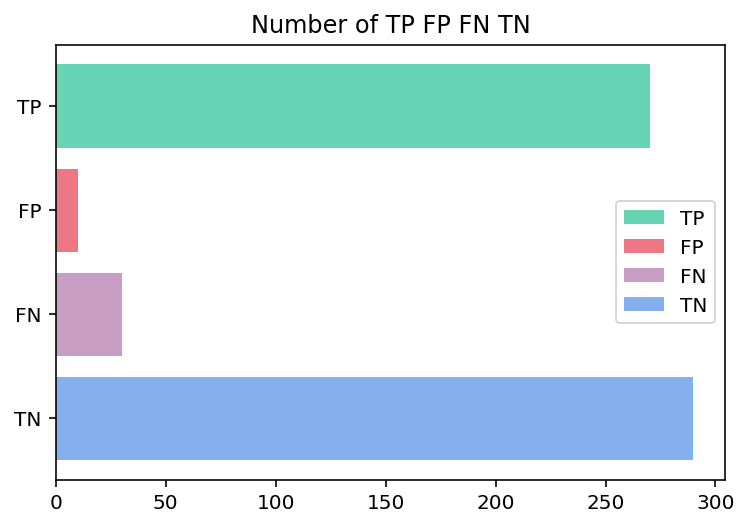

In [15]:
#スレットスコアを図として表示
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' #matplotlibのグラフをRetinaの高解像度で表示する
%matplotlib inline
plt.barh(4,TP,label = 'TP',color = '#67D5B5')
plt.barh(3,FP,label = 'FP',color ='#EE7785')
plt.barh(2,FN,label = 'FN',color = '#C89EC4')
plt.barh(1,TN,label = 'TN',color ='#84B1ED')
plt.legend()
plt.yticks([4,3,2,1],['TP','FP','FN','TN'])
plt.title('Number of TP FP FN TN')
plt.savefig('dataset3TN,TP,FP,FN.jpeg',dpi = 1600)

(1, 200, 200, 3)


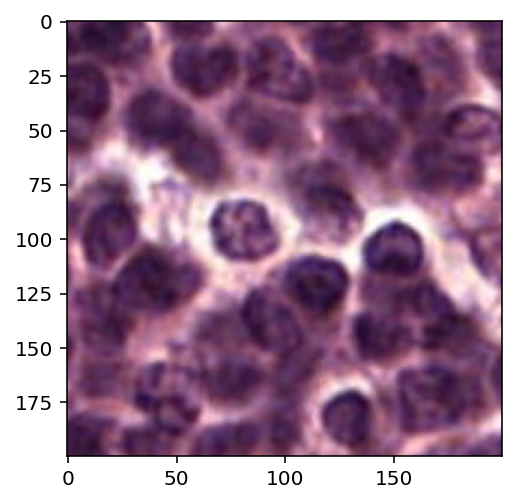

In [16]:
#＜＜中間層の出力を可視化する＞＞
#まずは単一画像を読み込み、前処理する((1, 200, 200, 3)の形にする)。

img_path = 'byori_dataset/train/normal/Image00h1200w800.bmp'

# この画像を四次元テンソルとして前処理
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(200, 200))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

# このモデルの訓練に使用された入力が次の方法で前処理されていることに注意
img_tensor /= 255.

# Its shape is (1, ２００, ２００, ３)
print(img_tensor.shape)

#　画像の表示
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

In [17]:
from keras import models

# 出力側の１８つの層から出力を抽出
layer_outputs = [layer.output for layer in vgg_model.layers[1:18]]

# 特定の入力をもとに、これらの出力を返すモデルを作成
activation_model = models.Model(inputs=vgg_model.input, outputs=layer_outputs)

# 17つのnumpy配列（層の活性化ごとに１つ）のリストを返す
activations = activation_model.predict(img_tensor)

#　最初の畳み込み層の活性化後の出力の形状(ちゃんと64chになっている)
first_layer_activation = activations[0] #([0]を[1]に変えると次の層の活性化後出力を取り出す)
print(first_layer_activation.shape)

(1, 200, 200, 64)


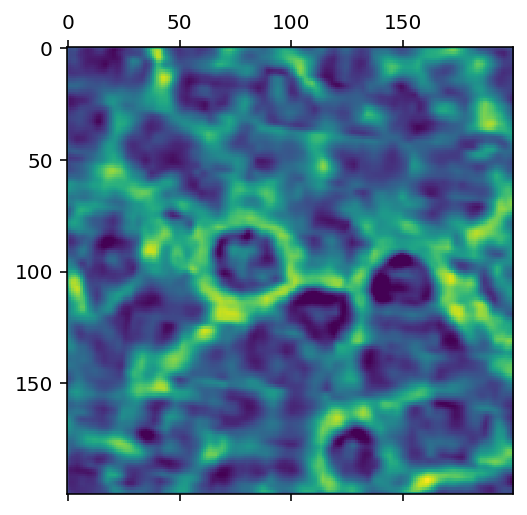

In [18]:
#　最初の畳み込み層の活性化後の出力の１番目のチャネルを表示
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')
plt.show()

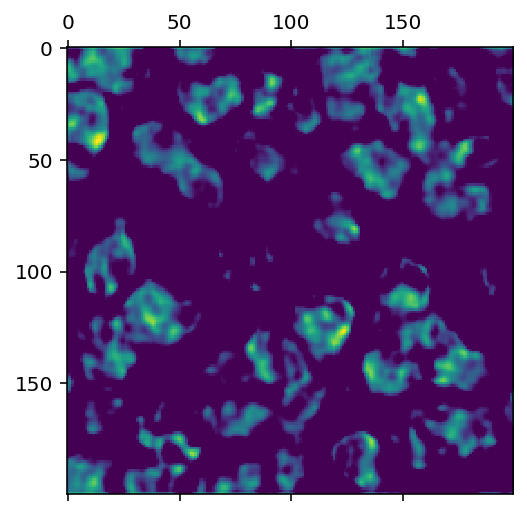

In [19]:
#　最初の畳み込み層の活性化後の出力の３９番目のチャネルを表示
plt.matshow(first_layer_activation[0, :, :, 39], cmap='viridis')
plt.show()

In [20]:
#　中間層の活性化ごとに全てのチャネルを可視化
import keras

# プロットの一部として使用する層の名前
layer_names = []
for layer in vgg_model.layers[:18]:
    layer_names.append(layer.name)

images_per_row = 16

# 特徴マップを表示する
for layer_name, layer_activation in zip(layer_names, activations):
    # 特徴マップに含まれている特徴量の数
    n_features = layer_activation.shape[-1]

    # 特徴マップの形状 (1, size, size, n_features)
    size = layer_activation.shape[1]

    # この行列で活性化のチャネルをタイル表示
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # 各フィルタを１つの大きな水平グリッドでタイル表示
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # 特徴量の見た目を良くするための後処理
            channel_image -= channel_image.mean()
            channel_image /= (channel_image.std() + 1e-7)
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # グリッドを表示
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
#    if layer_name =='input_2':
#        layer_name = layer_name[:-2]
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### 課題6-2-1
#### 今回は最後のFC層のみ学習し直しました。さらに正答率を上昇させるためにはconv層も再学習した方が良いです。
#### FC層の学習を行う前にconv層も一緒に学習し直すと、conv層の特徴が壊れてしまいます。
#### そのため、FC層の学習 --> 重みの保存 --> conv層(block5)とFC層の学習という手順で行います。やってみましょう。

### 課題6-2-2
#### 今回用いた病理画像データを用いて、他のモデル(InceptionV3など)を実装し高い正答率が出せるようにしましょう。
#### https://keras.io/ja/applications/ (<-様々なモデルが使えます)

### 課題6-2-3
#### 他の画像データセットを用いてみましょう。
#### https://github.com/arXivTimes/arXivTimes/tree/master/datasets (<-様々なデータセットが揃ってます)

In [21]:
# 14層目までのモデル重み固定を解除
for layer in vgg_model.layers[:15]:
    layer.trainable = True
        
vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [22]:
# 多クラス分類を指定
vgg_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
                  metrics=['accuracy'])

# 画像のジェネレータ生成
train_generator, validation_generator = image_generator()
    
#vgg_model.load_weights('dataset/results/finetuning.h5')
    
start = time.time()
# Fine-tuning
hist = vgg_model.fit(
    train_generator,
    steps_per_epoch = nb_train_samples/batch_size,
    epochs = nb_epoch,
    verbose = 1,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples/batch_size)

vgg_model.save_weights(os.path.join(result_dir, 'finetuning.h5'))

process_time = (time.time() - start) / 60
print(u'学習終了。かかった時間は', process_time, u'分です。')

Found 2000 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Epoch 1/10
50/50 [==============================] - 17s 302ms/step - loss: 0.8625 - accuracy: 0.5937 - val_loss: 0.6964 - val_accuracy: 0.4800
Epoch 2/10
50/50 [==============================] - 15s 306ms/step - loss: 0.6587 - accuracy: 0.5984 - val_loss: 0.2188 - val_accuracy: 0.9400
Epoch 3/10
50/50 [==============================] - 16s 315ms/step - loss: 0.1932 - accuracy: 0.9466 - val_loss: 1.0425 - val_accuracy: 0.5100
Epoch 4/10
50/50 [==============================] - 16s 309ms/step - loss: 0.4062 - accuracy: 0.8179 - val_loss: 0.1947 - val_accuracy: 0.9433
Epoch 5/10
50/50 [==============================] - 15s 303ms/step - loss: 0.4024 - accuracy: 0.8816 - val_loss: 0.2298 - val_accuracy: 0.9333
Epoch 6/10
50/50 [==============================] - 15s 303ms/step - loss: 0.0938 - accuracy: 0.9766 - val_loss: 0.2363 - val_accuracy: 0.9500
Epoch 7/10
50/50 [==============================] - 15s 306

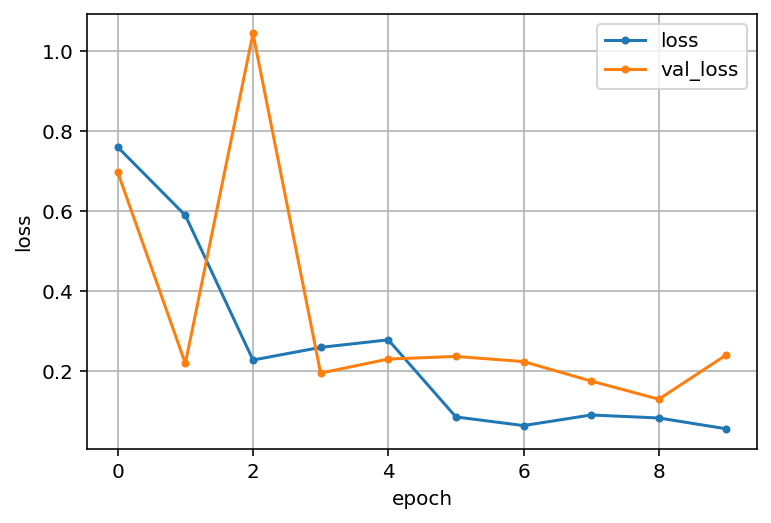

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = hist.history['loss']
val_loss = hist.history['val_loss']

# lossのグラフ
plt.plot(range(nb_epoch), loss, marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()